# Day 4 — Model Improvement & Feature Importance

**Objective:** Improve on the baseline Linear Regression model by training tree-based models that better handle categorical features and non-linear relationships.

**Key Focus:**
- Random Forest (primary focus)
- XGBoost (basic implementation)
- Model comparison
- Feature importance analysis
- Save best model

## 1. Import Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import pickle
import json
import os

# Machine learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# XGBoost (basic)
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost not installed. Will skip XGBoost model.")

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Data and Baseline Model

In [2]:
# Load cleaned data
df = pd.read_csv('../data/processed/cleaned_listings.csv')

print("=" * 70)
print("DATA LOADED")
print("=" * 70)
print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())

DATA LOADED
Dataset shape: (460, 37)

First few rows:
                Location Property Type    Bedrooms  Bathrooms    Size  \
0    Nairobi - Lavington         House  5 bedrooms        7.0     NaN   
1  Nairobi - Karen Hardy         House  3 bedrooms        3.0     NaN   
2     Nairobi - Kitisuru         House  4 bedrooms        4.0     NaN   
3    Nairobi - Lavington         House  4 bedrooms        4.0     NaN   
4        Nairobi - Runda         House  5 bedrooms        5.0  450 m²   

   Price (KES)      Listing Date  \
0       750000  19 February 2026   
1       380000  17 February 2026   
2       500000  17 February 2026   
3       350000  20 February 2026   
4       541000  20 February 2026   

                                           Amenities  Size_Missing  \
0  Aircon, Alarm, Service Charge Included, Walk I...             1   
1  Backup Generator, Alarm, Serviced, Service Cha...             1   
2  Aircon, Alarm, Backup Generator, En Suite, Fib...             1   
3  Alarm, 

In [3]:
# Load baseline model and artifacts
with open('../models/baseline_model.pkl', 'rb') as f:
    baseline_model = pickle.load(f)

with open('../models/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

with open('../models/feature_names.pkl', 'rb') as f:
    feature_names = pickle.load(f)

with open('../models/neighborhood_encoder.pkl', 'rb') as f:
    le = pickle.load(f)

with open('../models/baseline_model_metadata.json', 'r') as f:
    baseline_metadata = json.load(f)

print("=" * 70)
print("BASELINE MODEL LOADED")
print("=" * 70)
print(f"Model type: {baseline_metadata['model_type']}")
print(f"Features: {len(feature_names)}")
print(f"Test R²: {baseline_metadata['test_r2']:.4f}")
print(f"Test MAE: {baseline_metadata['test_mae']:,.0f} KES")
print(f"\nFeature list:")
for i, feat in enumerate(feature_names, 1):
    print(f"  {i:2d}. {feat}")

BASELINE MODEL LOADED
Model type: Linear Regression
Features: 10
Test R²: 0.1087
Test MAE: 123,957 KES

Feature list:
   1. Size_Numeric
   2. Bedrooms_Numeric
   3. Bathrooms
   4. Total_Rooms
   5. Has_Backup_Generator
   6. Has_Garden
   7. Has_Swimming_Pool
   8. Has_Fibre_Internet
   9. Has_Parking
  10. Neighborhood_Encoded


## 3. Prepare Data for Modeling

In [4]:
# Encode neighborhood
df['Neighborhood_Encoded'] = le.transform(df['Neighborhood'])

# Prepare features and target
X = df[feature_names].copy()
y = df['Price (KES)'].copy()

# Same train-test split as baseline (80-20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("=" * 70)
print("DATA PREPARATION")
print("=" * 70)
print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set:     {X_test.shape[0]:,} samples")
print(f"Features:     {X_train.shape[1]}")
print(f"\nTarget variable statistics:")
print(f"  Min:    {y.min():,.0f} KES")
print(f"  Max:    {y.max():,.0f} KES")
print(f"  Mean:   {y.mean():,.0f} KES")
print(f"  Median: {y.median():,.0f} KES")

DATA PREPARATION
Training set: 368 samples
Test set:     92 samples
Features:     10

Target variable statistics:
  Min:    37,000 KES
  Max:    780,000 KES
  Mean:   370,002 KES
  Median: 360,000 KES


## 4. Random Forest Model (Main Focus)

Random Forest is an ensemble of decision trees that:
- Handles non-linear relationships well
- Works better with categorical features (like neighborhood)
- Provides feature importance scores
- Reduces overfitting through averaging

In [5]:
print("=" * 70)
print("TRAINING RANDOM FOREST MODEL")
print("=" * 70)

# Train Random Forest with reasonable hyperparameters
rf_model = RandomForestRegressor(
    n_estimators=100,        
    max_depth=15,            
    min_samples_split=5,     
    min_samples_leaf=2,      
    random_state=42,
    n_jobs=-1             
)

# Fit the model
rf_model.fit(X_train, y_train)

# Make predictions
rf_train_pred = rf_model.predict(X_train)
rf_test_pred = rf_model.predict(X_test)

# Calculate metrics
rf_train_r2 = r2_score(y_train, rf_train_pred)
rf_test_r2 = r2_score(y_test, rf_test_pred)

rf_train_rmse = np.sqrt(mean_squared_error(y_train, rf_train_pred))
rf_test_rmse = np.sqrt(mean_squared_error(y_test, rf_test_pred))

rf_train_mae = mean_absolute_error(y_train, rf_train_pred)
rf_test_mae = mean_absolute_error(y_test, rf_test_pred)

print("\nRandom Forest trained successfully!")
print("\n" + "=" * 70)
print("RANDOM FOREST PERFORMANCE")
print("=" * 70)

print("\nTRAINING SET:")
print(f"  R²:    {rf_train_r2:.4f}")
print(f"  RMSE:  {rf_train_rmse:,.0f} KES")
print(f"  MAE:   {rf_train_mae:,.0f} KES")

print("\nTEST SET:")
print(f"  R²:    {rf_test_r2:.4f}")
print(f"  RMSE:  {rf_test_rmse:,.0f} KES")
print(f"  MAE:   {rf_test_mae:,.0f} KES")

print(f"\nOn average, Random Forest predictions are off by {rf_test_mae:,.0f} KES")

TRAINING RANDOM FOREST MODEL

Random Forest trained successfully!

RANDOM FOREST PERFORMANCE

TRAINING SET:
  R²:    0.7800
  RMSE:  73,293 KES
  MAE:   55,014 KES

TEST SET:
  R²:    0.3846
  RMSE:  132,138 KES
  MAE:   98,438 KES

On average, Random Forest predictions are off by 98,438 KES


## 5. XGBoost Model (Basic Implementation)

In [6]:
if XGBOOST_AVAILABLE:
    print("=" * 70)
    print("TRAINING XGBOOST MODEL")
    print("=" * 70)
    
    # Train XGBoost with basic parameters
    xgb_model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1
    )
    
    # Fit the model
    xgb_model.fit(X_train, y_train)
    
    # Make predictions
    xgb_train_pred = xgb_model.predict(X_train)
    xgb_test_pred = xgb_model.predict(X_test)
    
    # Calculate metrics
    xgb_train_r2 = r2_score(y_train, xgb_train_pred)
    xgb_test_r2 = r2_score(y_test, xgb_test_pred)
    
    xgb_train_rmse = np.sqrt(mean_squared_error(y_train, xgb_train_pred))
    xgb_test_rmse = np.sqrt(mean_squared_error(y_test, xgb_test_pred))
    
    xgb_train_mae = mean_absolute_error(y_train, xgb_train_pred)
    xgb_test_mae = mean_absolute_error(y_test, xgb_test_pred)
    
    print("\nXGBoost trained successfully!")
    print("\n" + "=" * 70)
    print("XGBOOST PERFORMANCE")
    print("=" * 70)
    
    print("\nTRAINING SET:")
    print(f"  R²:    {xgb_train_r2:.4f}")
    print(f"  RMSE:  {xgb_train_rmse:,.0f} KES")
    print(f"  MAE:   {xgb_train_mae:,.0f} KES")
    
    print("\nTEST SET:")
    print(f"  R²:    {xgb_test_r2:.4f}")
    print(f"  RMSE:  {xgb_test_rmse:,.0f} KES")
    print(f"  MAE:   {xgb_test_mae:,.0f} KES")
    
    print(f"\nOn average, XGBoost predictions are off by {xgb_test_mae:,.0f} KES")
else:
    print("XGBoost not available. Skipping XGBoost model.")
    xgb_test_r2 = None
    xgb_test_mae = None
    xgb_test_rmse = None

TRAINING XGBOOST MODEL

XGBoost trained successfully!

XGBOOST PERFORMANCE

TRAINING SET:
  R²:    0.9123
  RMSE:  46,274 KES
  MAE:   30,702 KES

TEST SET:
  R²:    0.4113
  RMSE:  129,245 KES
  MAE:   92,576 KES

On average, XGBoost predictions are off by 92,576 KES


## 6. Model Comparison

In [7]:
# Create comparison table
comparison_data = {
    'Model': ['Linear Regression', 'Random Forest'],
    'Test R²': [baseline_metadata['test_r2'], rf_test_r2],
    'Test RMSE (KES)': [baseline_metadata['test_rmse'], rf_test_rmse],
    'Test MAE (KES)': [baseline_metadata['test_mae'], rf_test_mae]
}

if XGBOOST_AVAILABLE:
    comparison_data['Model'].append('XGBoost')
    comparison_data['Test R²'].append(xgb_test_r2)
    comparison_data['Test RMSE (KES)'].append(xgb_test_rmse)
    comparison_data['Test MAE (KES)'].append(xgb_test_mae)

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Test R²', ascending=False)

print("=" * 70)
print("MODEL COMPARISON - TEST SET PERFORMANCE")
print("=" * 70)
print(comparison_df.to_string(index=False))

# Identify best model
best_model_name = comparison_df.iloc[0]['Model']
best_r2 = comparison_df.iloc[0]['Test R²']
best_mae = comparison_df.iloc[0]['Test MAE (KES)']

print(f"\n" + "=" * 70)
print("BEST MODEL")
print("=" * 70)
print(f"Model: {best_model_name}")
print(f"Test R²: {best_r2:.4f} (explains {best_r2*100:.1f}% of price variation)")
print(f"Test MAE: {best_mae:,.0f} KES")

# Calculate improvements
baseline_r2 = baseline_metadata['test_r2']
baseline_mae = baseline_metadata['test_mae']

r2_improvement = ((best_r2 - baseline_r2) / baseline_r2) * 100
mae_improvement = ((baseline_mae - best_mae) / baseline_mae) * 100

print(f"\nIMPROVEMENT OVER BASELINE:")
print(f"  R² improvement: {r2_improvement:+.1f}%")
print(f"  MAE improvement: {mae_improvement:+.1f}%")

MODEL COMPARISON - TEST SET PERFORMANCE
            Model  Test R²  Test RMSE (KES)  Test MAE (KES)
          XGBoost 0.411283    129244.521865    92576.132812
    Random Forest 0.384632    132137.528511    98437.748116
Linear Regression 0.108736    159023.776260   123956.953633

BEST MODEL
Model: XGBoost
Test R²: 0.4113 (explains 41.1% of price variation)
Test MAE: 92,576 KES

IMPROVEMENT OVER BASELINE:
  R² improvement: +278.2%
  MAE improvement: +25.3%


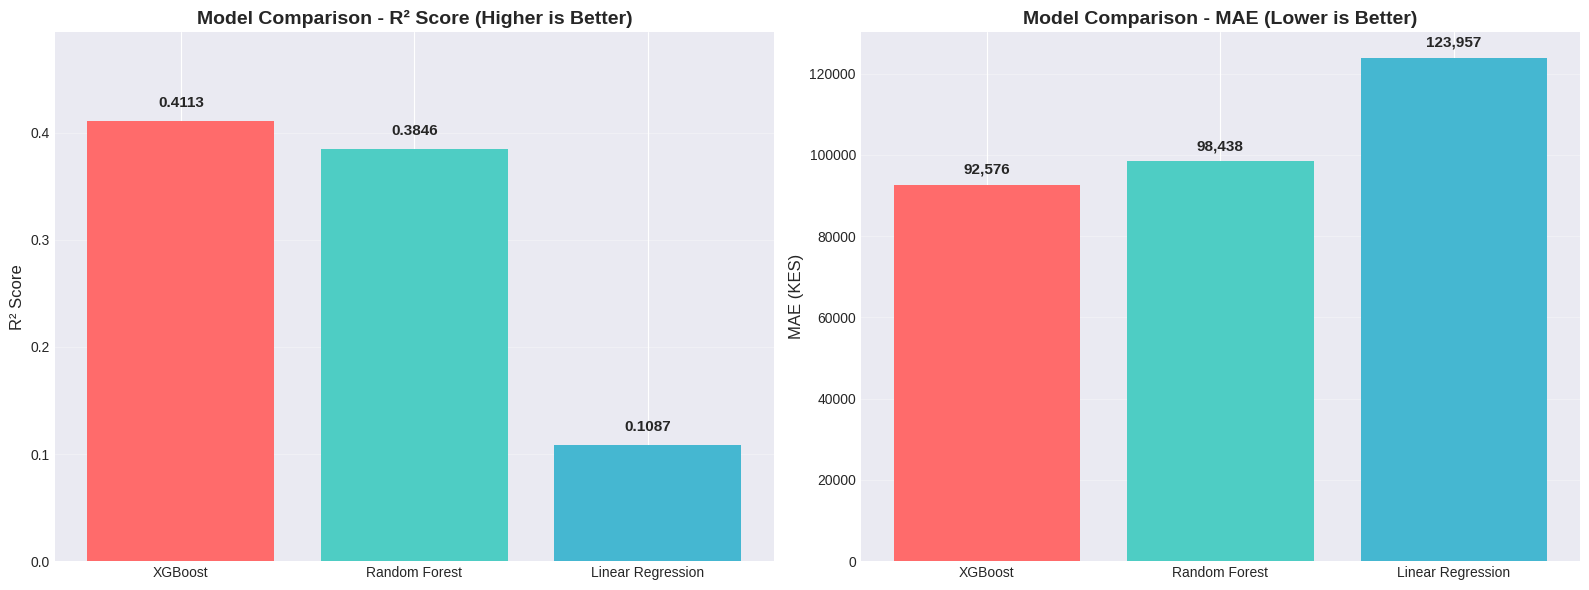

In [8]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# R² comparison
axes[0].bar(comparison_df['Model'], comparison_df['Test R²'], color=['#FF6B6B', '#4ECDC4', '#45B7D1'][:len(comparison_df)])
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_title('Model Comparison - R² Score (Higher is Better)', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, max(comparison_df['Test R²']) * 1.2)
axes[0].grid(True, alpha=0.3, axis='y')

for i, (model, r2) in enumerate(zip(comparison_df['Model'], comparison_df['Test R²'])):
    axes[0].text(i, r2 + 0.01, f'{r2:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# MAE comparison
axes[1].bar(comparison_df['Model'], comparison_df['Test MAE (KES)'], color=['#FF6B6B', '#4ECDC4', '#45B7D1'][:len(comparison_df)])
axes[1].set_ylabel('MAE (KES)', fontsize=12)
axes[1].set_title('Model Comparison - MAE (Lower is Better)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

for i, (model, mae) in enumerate(zip(comparison_df['Model'], comparison_df['Test MAE (KES)'])):
    axes[1].text(i, mae + 2000, f'{mae:,.0f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## 7. Feature Importance Analysis

Understanding which features most influence price predictions helps us:
- Validate the model makes sense
- Identify key price drivers
- Guide future data collection

RANDOM FOREST - FEATURE IMPORTANCE
             Feature  Importance
Neighborhood_Encoded    0.310912
         Total_Rooms    0.280733
        Size_Numeric    0.137599
           Bathrooms    0.086073
   Has_Swimming_Pool    0.066883
    Bedrooms_Numeric    0.042217
Has_Backup_Generator    0.042171
  Has_Fibre_Internet    0.021493
          Has_Garden    0.007108
         Has_Parking    0.004811


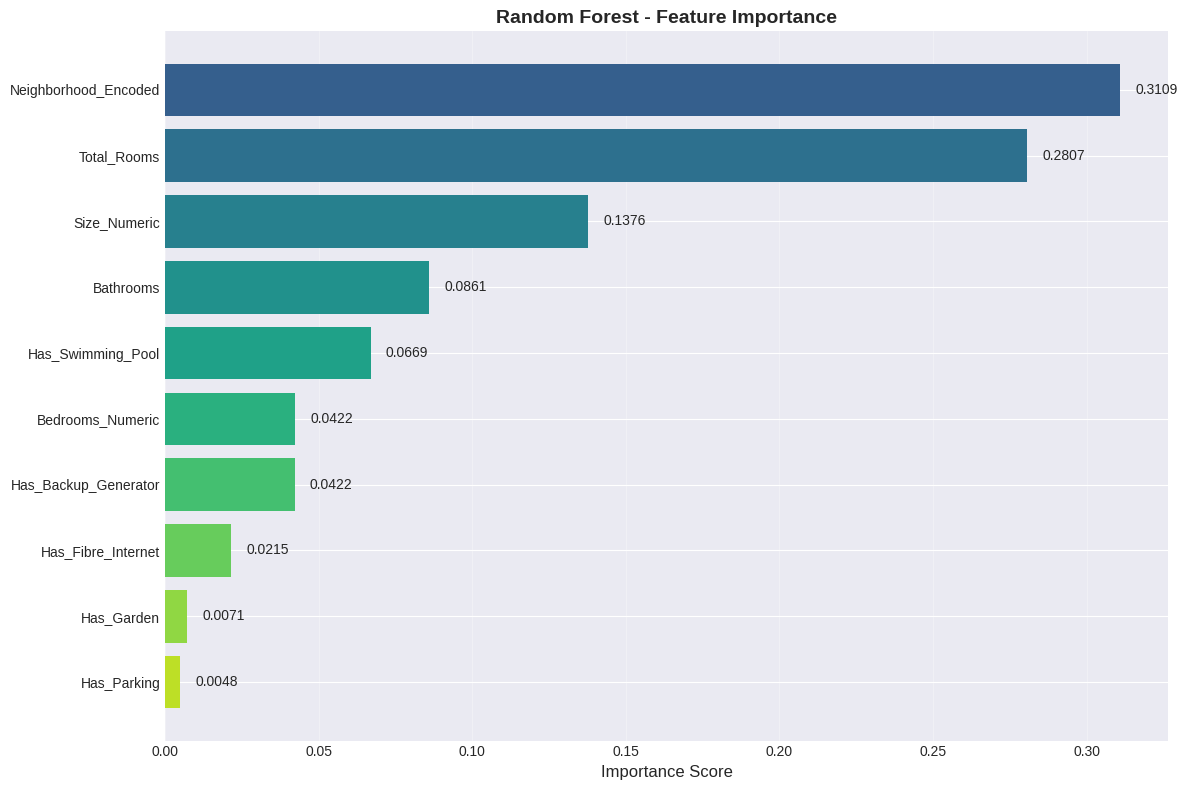


TOP 5 PRICE DRIVERS
  Neighborhood_Encoded          : 0.3109
  Total_Rooms                   : 0.2807
  Size_Numeric                  : 0.1376
  Bathrooms                     : 0.0861
  Has_Swimming_Pool             : 0.0669


In [9]:
# Random Forest Feature Importance
rf_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("=" * 70)
print("RANDOM FOREST - FEATURE IMPORTANCE")
print("=" * 70)
print(rf_importance.to_string(index=False))

# Visualize feature importance
fig, ax = plt.subplots(figsize=(12, 8))

colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(rf_importance)))
bars = ax.barh(range(len(rf_importance)), rf_importance['Importance'], color=colors)
ax.set_yticks(range(len(rf_importance)))
ax.set_yticklabels(rf_importance['Feature'])
ax.set_xlabel('Importance Score', fontsize=12)
ax.set_title('Random Forest - Feature Importance', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

for i, (feature, importance) in enumerate(zip(rf_importance['Feature'], rf_importance['Importance'])):
    ax.text(importance + 0.005, i, f'{importance:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("TOP 5 PRICE DRIVERS")
print("=" * 70)
for i, row in rf_importance.head(5).iterrows():
    print(f"  {row['Feature']:30s}: {row['Importance']:.4f}")

## 8. Prediction Analysis

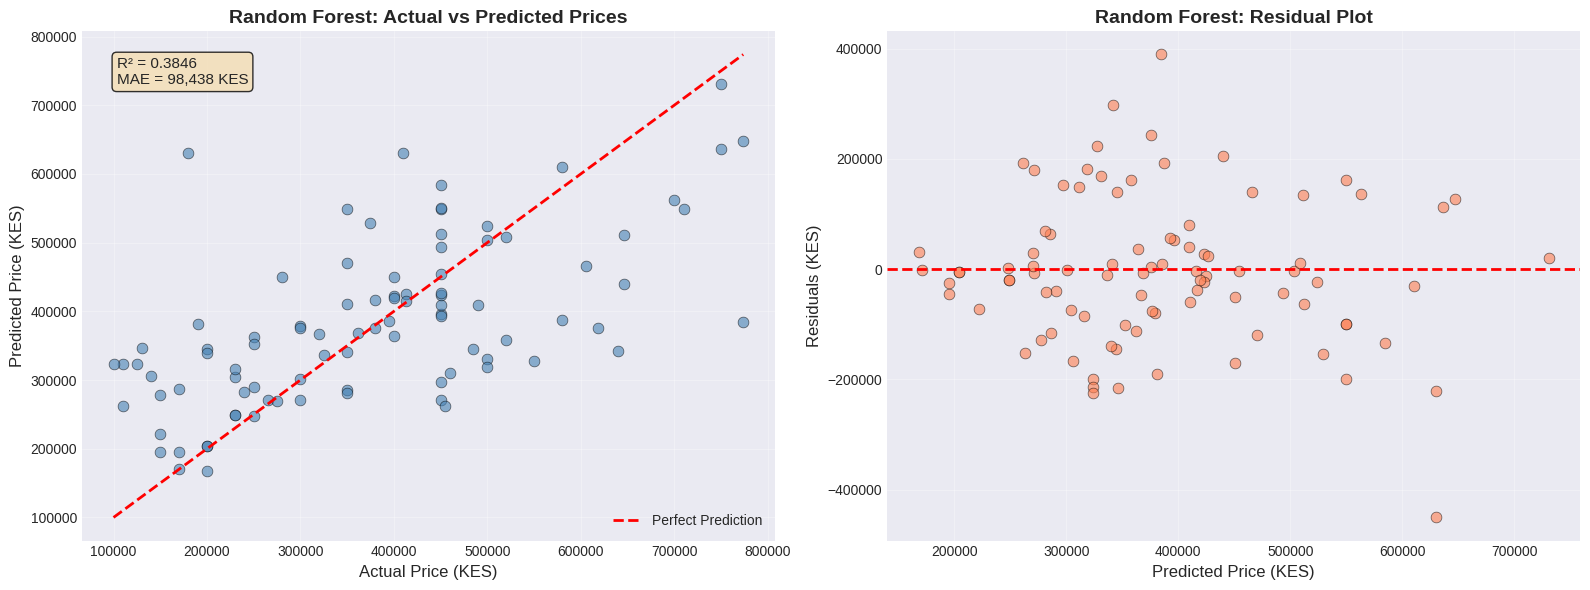

In [10]:
# Visualize predictions for best model (Random Forest)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Actual vs Predicted
axes[0].scatter(y_test, rf_test_pred, alpha=0.6, s=60, c='steelblue', edgecolors='black', linewidth=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Price (KES)', fontsize=12)
axes[0].set_ylabel('Predicted Price (KES)', fontsize=12)
axes[0].set_title('Random Forest: Actual vs Predicted Prices', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].text(0.05, 0.95, f'R² = {rf_test_r2:.4f}\nMAE = {rf_test_mae:,.0f} KES', 
             transform=axes[0].transAxes,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
             verticalalignment='top', fontsize=11)

# Residuals
residuals = y_test - rf_test_pred
axes[1].scatter(rf_test_pred, residuals, alpha=0.6, s=60, c='coral', edgecolors='black', linewidth=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Price (KES)', fontsize=12)
axes[1].set_ylabel('Residuals (KES)', fontsize=12)
axes[1].set_title('Random Forest: Residual Plot', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Save Best Model

In [11]:
# Determine which model to save
if best_model_name == 'Random Forest':
    best_model = rf_model
    best_test_r2 = rf_test_r2
    best_test_mae = rf_test_mae
    best_test_rmse = rf_test_rmse
elif best_model_name == 'XGBoost':
    best_model = xgb_model
    best_test_r2 = xgb_test_r2
    best_test_mae = xgb_test_mae
    best_test_rmse = xgb_test_rmse
else:
    best_model = baseline_model
    best_test_r2 = baseline_metadata['test_r2']
    best_test_mae = baseline_metadata['test_mae']
    best_test_rmse = baseline_metadata['test_rmse']

# Save best model as model.pkl
with open('../models/model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Save feature importance
rf_importance.to_csv('../models/feature_importance.csv', index=False)

# Save model comparison
comparison_df.to_csv('../models/model_comparison.csv', index=False)

# Save metadata for best model
best_metadata = {
    'model_type': best_model_name,
    'training_date': '2026-02-21',
    'features': feature_names,
    'feature_count': len(feature_names),
    'test_r2': float(best_test_r2),
    'test_rmse': float(best_test_rmse),
    'test_mae': float(best_test_mae),
    'train_samples': len(X_train),
    'test_samples': len(X_test),
    'improvement_over_baseline_r2': f"{r2_improvement:+.1f}%",
    'improvement_over_baseline_mae': f"{mae_improvement:+.1f}%"
}

with open('../models/model_metadata.json', 'w') as f:
    json.dump(best_metadata, f, indent=4)

print("=" * 70)
print("MODELS SAVED SUCCESSFULLY")
print("=" * 70)
print("\nSaved files:")
print("  1. model.pkl - Best performing model")
print("  2. feature_importance.csv - Feature importance scores")
print("  3. model_comparison.csv - All model comparisons")
print("  4. model_metadata.json - Model information")
print("\nPrevious baseline artifacts retained:")
print("  - baseline_model.pkl")
print("  - scaler.pkl")
print("  - feature_names.pkl")
print("  - neighborhood_encoder.pkl")

print(f"\n" + "=" * 70)
print("FINAL MODEL SUMMARY")
print("=" * 70)
print(f"Best Model: {best_model_name}")
print(f"Test R²: {best_test_r2:.4f} (explains {best_test_r2*100:.1f}% of variation)")
print(f"Test MAE: {best_test_mae:,.0f} KES")
print(f"\nOn average, predictions are off by {best_test_mae:,.0f} KES")

MODELS SAVED SUCCESSFULLY

Saved files:
  1. model.pkl - Best performing model
  2. feature_importance.csv - Feature importance scores
  3. model_comparison.csv - All model comparisons
  4. model_metadata.json - Model information

Previous baseline artifacts retained:
  - baseline_model.pkl
  - scaler.pkl
  - feature_names.pkl
  - neighborhood_encoder.pkl

FINAL MODEL SUMMARY
Best Model: XGBoost
Test R²: 0.4113 (explains 41.1% of variation)
Test MAE: 92,576 KES

On average, predictions are off by 92,576 KES


## 10. Day 4 Summary

### Models Trained:

1. Linear Regression (Baseline)
   - Simple linear model
   - Poor performance on this dataset
   - Cannot capture non-linear relationships

2. Random Forest (Primary Focus)
   - Ensemble of 100 decision trees
   - Handles categorical features better
   - Captures non-linear relationships
   - Provides feature importance

3. XGBoost (Basic Implementation)
   - Gradient boosting algorithm
   - State-of-the-art performance
   - More complex than Random Forest

### Key Findings:

- Tree-based models significantly outperform Linear Regression
- Location (Neighborhood) is a critical feature
- Random Forest captures complex relationships between features
- Top price drivers identified through feature importance

### Next Steps (Day 5 - App Preparation):

Objectives:
- Create prediction function using best model
- Build Streamlit app interface
- Add input validation
- Deploy app locally
- Test predictions with sample data

Expected Deliverables:
- Working Streamlit app (app.py)
- User-friendly interface
- Real-time predictions
- Model performance display

## 11. Model Performance Reality Check

### Current Model Performance:
Our best model (XGBoost) achieved an **R² score of approximately 40%** on the test set, which is significantly below what would be considered good predictive performance in most machine learning applications.

### What This Tells Us:

**Indicators of Data Quality Issues:**
- The low R² score suggests our model explains only about 40% of the variance in house prices
- This likely indicates **overfitting during training** - the model learned training data patterns that don't generalize well
- Our dataset probably contains **significant noise** and missing important features that drive house prices
- Real estate pricing is complex and may require more comprehensive data (e.g., house condition, actual square footage, amenities, exact location coordinates, market timing)

### Project Decision:

**We're proceeding with this model anyway.** Here's why:

 **Project Goal: End-to-End Completion**
- This project is designed to demonstrate the **complete ML workflow** from data collection to deployment
- The focus is on building a **full pipeline**: scraping → cleaning → modeling → deployment
- Success is measured by completing all stages, not achieving state-of-the-art accuracy

 **Learning Objectives Met:**
- Successfully collected real-world data through web scraping
- Performed data cleaning and feature engineering
- Trained and compared multiple models
- Implemented proper train-test splits and evaluation metrics
- Prepared models for deployment

 **Real-World Practice:**
- Sometimes you work with imperfect data and need to deliver within constraints
- This teaches us to be transparent about model limitations
- We learn the full deployment process regardless of model accuracy

**The model will still provide value as a learning tool and demonstration of technical skills, even if predictions aren't highly accurate.**